In [11]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [12]:
# Caricamento del dataset
file_path = 'data-istruzioni/Data.xlsx'
data = pd.read_excel(file_path)

# Rimozione colonne inutili
data_cleaned = data.drop(columns=['ID'])

# Suddivisione in Training, Validation e Test set prima di gestire i valori nulli
X = data_cleaned.iloc[:, :-1]
y = data_cleaned.iloc[:, -1]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Gestione valori mancanti: sostituisce i NaN con la media per colonne numeriche
numerical_imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(numerical_imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(numerical_imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(numerical_imputer.transform(X_test), columns=X_test.columns)

# Verifica dimensioni dei set
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (55, 249), Validation set: (12, 249), Test set: (12, 249)


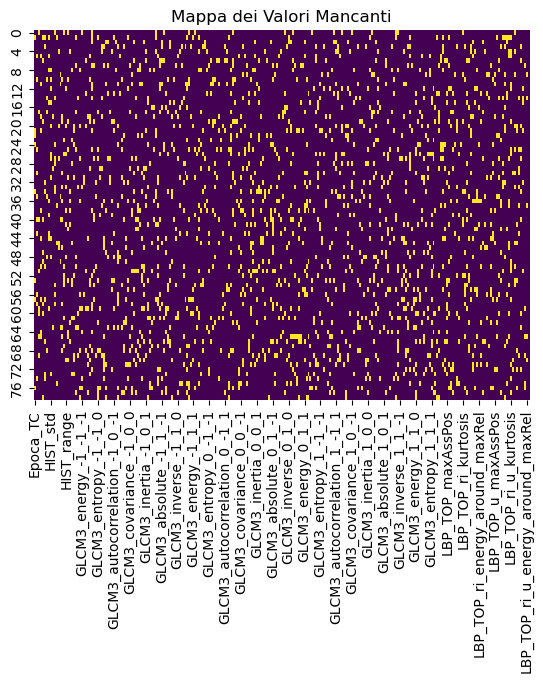

In [13]:
sns.heatmap(data_cleaned.isnull(), cbar=False, cmap='viridis')
plt.title('Mappa dei Valori Mancanti')
plt.show()

In [14]:
# Selezione delle migliori 10 feature
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)

# Trasforma anche il Validation e il Test set
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# Salva il selettore per future predizioni
joblib.dump(selector, 'feature_selector.pkl')

/home/elly/miniconda3/envs/NYC/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [222 223 224 234 246] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/elly/miniconda3/envs/NYC/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


['feature_selector.pkl']

In [15]:
# Creazione della pipeline per preprocessing e classificatore
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling dei dati
    ('svc', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))  # Modello SVC
])

svc_pipeline.fit(X_train_selected, y_train)

# Predizioni
y_pred = svc_pipeline.predict(X_test_selected)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Salva il modello
joblib.dump(svc_pipeline, 'final_model.pkl')



Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.67      0.86      0.75         7

    accuracy                           0.67        12
   macro avg       0.67      0.63      0.62        12
weighted avg       0.67      0.67      0.65        12



['final_model.pkl']

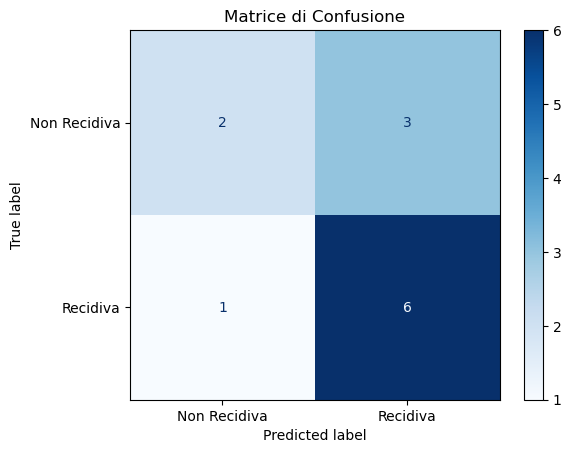

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non Recidiva', 'Recidiva'])
disp.plot(cmap='Blues')
plt.title('Matrice di Confusione')
plt.show()


In [22]:
# Mostra le feature selezionate
selected_features = X.columns[selector.get_support()]
print("Feature selezionate:", selected_features.tolist())

Feature selezionate: ['Epoca_TC', 'Area_grasso_periviscerale', 'GS_alla_diagnosi', 'TNM_alla_diagnosi', 'Eta_alla_RP', 'GLCM3_entropy_-1_0_-1', 'GLCM3_inverse_1_-1_0', 'GLCM3_entropy_1_0_-1', 'GLCM3_autocorrelation_1_0_1', 'LBP_TOP_range']


In [17]:
# Valutazione sul Validation set
y_val_pred = svc_pipeline.predict(X_val_selected)

print("\nValutazione sul Validation Set:")
print(classification_report(y_val, y_val_pred))
print("\nMatrice di confusione sul Validation Set:")
print(confusion_matrix(y_val, y_val_pred))


Valutazione sul Validation Set:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.56      0.71      0.62         7

    accuracy                           0.50        12
   macro avg       0.44      0.46      0.44        12
weighted avg       0.46      0.50      0.47        12


Matrice di confusione sul Validation Set:
[[1 4]
 [2 5]]


In [18]:
# Valutazione sul Test set
y_test_pred = svc_pipeline.predict(X_test_selected)

print("\nValutazione sul Test Set:")
print(classification_report(y_test, y_test_pred))
print("\nMatrice di confusione sul Test Set:")
print(confusion_matrix(y_test, y_test_pred))


Valutazione sul Test Set:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.67      0.86      0.75         7

    accuracy                           0.67        12
   macro avg       0.67      0.63      0.62        12
weighted avg       0.67      0.67      0.65        12


Matrice di confusione sul Test Set:
[[2 3]
 [1 6]]


In [19]:
# Valutazione globale del modello
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("\nMetriche globali sul Test Set:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Metriche globali sul Test Set:
Accuracy: 0.67
Precision: 0.67
Recall: 0.86
F1-Score: 0.75


In [20]:
# Cross-Validation
cv_scores = cross_val_score(svc_pipeline, X_val_selected, y_val, cv=5, scoring='accuracy')

print("\nCross-Validation Scores (Accuracy):", cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation: {cv_scores.std():.2f}")


Cross-Validation Scores (Accuracy): [0.33333333 0.66666667 0.5        0.5        0.5       ]
Mean Accuracy: 0.50
Standard Deviation: 0.11


In [27]:
# Funzione per testare tutti i dati nel test set
def test_full_test_set():
    # Trasforma il test set con il selettore di feature
    X_test_selected = selector.transform(X_test)

    # Predizioni sul test set
    predictions = svc_pipeline.predict(X_test_selected)

    # Confronto con i valori reali
    correct_predictions = (y_test == predictions).sum()
    total_predictions = len(y_test)
    accuracy_on_test = correct_predictions / total_predictions

    print("\nRisultati sui dati di Test Set:")
    for i, pred in enumerate(predictions):
        print(f"Esempio {i+1}: {'Recidiva' if pred == 1 else 'Non Recidiva'} (Reale: {'Recidiva' if y_test.iloc[i] == 1 else 'Non Recidiva'})")

    print(f"\nNumero di predizioni corrette: {correct_predictions}")
    print(f"Totale predizioni: {total_predictions}")
    print(f"Accuracy sul Test Set: {accuracy_on_test:.2f}")


In [28]:
test_full_test_set()



Risultati sui dati di Test Set:
Esempio 1: Recidiva (Reale: Non Recidiva)
Esempio 2: Recidiva (Reale: Recidiva)
Esempio 3: Recidiva (Reale: Recidiva)
Esempio 4: Recidiva (Reale: Recidiva)
Esempio 5: Recidiva (Reale: Non Recidiva)
Esempio 6: Recidiva (Reale: Recidiva)
Esempio 7: Non Recidiva (Reale: Non Recidiva)
Esempio 8: Non Recidiva (Reale: Recidiva)
Esempio 9: Recidiva (Reale: Non Recidiva)
Esempio 10: Recidiva (Reale: Recidiva)
Esempio 11: Non Recidiva (Reale: Non Recidiva)
Esempio 12: Recidiva (Reale: Recidiva)

Numero di predizioni corrette: 8
Totale predizioni: 12
Accuracy sul Test Set: 0.67
